### Modified PVU/GPH FCNN model file from November of 2024 to meet the needs of my current work. 

This will be a three-input merged model of flattened vertical cross sections for Zonal-mean wind, GPH, and Zonal-mean meridional eddy heat flux. 

File initalized on June 25, 2025. 

First two cells are for imports. 

In [1]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

##plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

In [2]:
##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
#necessary for this model because I need to use LRP for XAI. 
#import innvestigate
import investigate

2025-06-27 17:37:41.196985: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 17:37:41.198966: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-27 17:37:41.225832: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-27 17:37:41.225852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-27 17:37:41.225871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [3]:
print(tf.__version__)

2.14.1


#### Upload data. 

In [4]:
#load input data
infile = open("../eof_data/vertanom_u.p","rb",)
u_input = pickle.load(infile)  ##vertical U cross section
#flat_u_14 = u_input[:62, 19:168, :, :].reshape((62 * 149, 37, 36))
infile.close()

infile = open("../eof_data/vertanom_ehf.p","rb",)
ehf_input = pickle.load(infile)  ##ZMehf vertical cross section along longitudes
#flat_EHF_14 = ehf_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

infile = open("../eof_data/vertanom_gph.p","rb",)
gph_input = pickle.load(infile)  ##GPH vertical cross section along longitudes
#flat_GPH_14= gph_input[:62, 19:168, :, :].reshape((62 * 149, 37, 180))
infile.close()

In [5]:
##max min normalize arrays 
u_input = (u_input -u_input.min()) / (u_input.max() - u_input.min())
ehf_input = (ehf_input -ehf_input.min()) / (ehf_input.max() - ehf_input.min())
gph_input = (gph_input -gph_input.min()) / (gph_input.max() - gph_input.min())

In [6]:
##19:168 for 14 days and 
##19:162 for 20 days and 
##19:152 for 30 days. 

u_14 = u_input[:62, 19:168, :, :]
EHF_14 = ehf_input[:62, 19:168, :, :]
GPH_14= gph_input[:62, 19:168, :, :]

print("U Wind shape: ",u_14.shape)
print("EHF shape: ",EHF_14.shape)
print("GPH shape: ",GPH_14.shape)

U Wind shape:  (62, 149, 37, 36)
EHF shape:  (62, 149, 37, 180)
GPH shape:  (62, 149, 37, 180)


In [11]:
# load output data
# 149 for 14
# 143 for 20 and 
# 133 for 30 

infile = open("../reduced_data/temps/eur_14.p","rb",)
output = pickle.load(infile) 
output = output.reshape(62, 149)
infile.close()

In [12]:
temp = output[:,:]
print(temp.shape)

(62, 149)


The next two cells are only relevant for lead times >14 days. 

In [13]:
lead = 149

In [14]:
#this can be commented out if not needed. 
input_u =  u_14
input_ehf =  EHF_14
input_gph =  GPH_14
temp_n = temp

In [15]:
##input shape (samples, lat, lon) and (#samples, window, features)
print(input_u.shape)
print(input_ehf.shape)
print(input_gph.shape)

(62, 149, 37, 36)
(62, 149, 37, 180)
(62, 149, 37, 180)


In [16]:
##output shape (samples), these will be different from the input
temp_n.shape

(62, 149)

In [17]:
frac_ind = round((62*lead)*0.15)
frac_end = round((62*lead)-frac_ind)
frac_end

7852

In [18]:
##Set X_all and Y_all datasets
X_all1 = np.copy(input_u.reshape(62*lead,37*36)) ##u
X_all2 = np.copy(input_ehf.reshape(62*lead,37*180)) ##ehf
X_all3 = np.copy(input_gph.reshape(62*lead,37*180)) ##gph

Y_all = np.copy(temp_n.reshape(62*lead))

##training data partition out
X_tri1 = X_all1[:frac_end,:] ##u
X_tri2 = X_all2[:frac_end,:] ##ehf
X_tri3 = X_all3[:frac_end,:] ##gph

Y_tri = Y_all[:frac_end]

#testing data partition out
X_tes1 = X_all1[frac_end:,:]
X_tes2 = X_all2[frac_end:,:]
X_tes3 = X_all3[frac_end:,:]

Y_tes = Y_all[frac_end:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [19]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all2)) or np.any(np.isinf(X_all2)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin establishing specifics of model.

In [20]:
##set 15% of data for validation
frac_ind

1386

In [21]:
##checking to make sure shape was properly one hot encoded
Y_all.shape

(9238, 2)

In [22]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [23]:
##number of input nodes
input_shape1=  X_all1.shape[-1] # u
input_shape2= X_all2.shape[-1] ## ehf
input_shape3= X_all3.shape[-1] ## gph


##fraction of training data
X_validation1 = X_tri1[0:frac_ind]
X_validation2 = X_tri2[0:frac_ind]
X_validation3 = X_tri3[0:frac_ind]
Y_validation = Y_tri[0:frac_ind]
        
X_train1 = X_tri1[frac_ind:len(X_tri1)]
X_train2 = X_tri2[frac_ind:len(X_tri2)]
X_train3 = X_tri3[frac_ind:len(X_tri3)]
Y_train = Y_tri[frac_ind:len(Y_tri)]

X_test1 = X_tes1
X_test2 = X_tes2
X_test3 = X_tes3
Y_test = Y_tes

In [24]:
Y_train.shape

(6466, 2)

In [25]:
input_shape1

1332

In [26]:
input_shape2

6660

In [27]:
input_shape3

6660

In [28]:
##do the class_dict weights
class_weight = class_weight_creator(Y_train)
class_weight

{0: 1.0, 1: 1.5238096}

### Model Arcitecture.

In [29]:
def combined(n1, n2, n3, n4, n5, n6, n7, reg1, reg2, reg3, reg4, reg5, reg6, reg7, learn):
    ##first layers for U ANN
    input_tensor1 = Input(shape=(int(1332),), name='layer1')
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   

    layer1 = layers.Dense(n2, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
   
    ## second layers for EHF ANN
    input_tensor2 = Input(shape=(int(6660),), name='layer2')
    layer2 = layers.Dense(n3, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(input_tensor2)
    
    layer2 = layers.Dense(n4, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)
    
    
    ## third layers for GPH ANN
    input_tensor3 = Input(shape=(int(6660),), name='layer3')
    layer3 = layers.Dense(n5, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg5))(input_tensor3)
    
    layer3 = layers.Dense(n6, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg6))(layer3)
    
    ##combine two model inputs
    merge_layer = Concatenate()([layer1,layer2,layer3])

    ##more dense layers
    merge = layers.Dense(n7, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg7))(merge_layer)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(2,activation='softmax')(merge)
    model = Model([input_tensor1, input_tensor2, input_tensor3], output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [30]:
##dictionaries for training and validation
X_train = {'layer1': X_train1, 'layer2': X_train2, 'layer3': X_train3}
X_all = {'layer1': X_all1, 'layer2': X_all2, 'layer3': X_all3}
X_test = {'layer1': X_test1, 'layer2': X_test2, 'layer3': X_test3}
X_val = {'layer1': X_validation1, 'layer2': X_validation2, 'layer3': X_validation3}

In [31]:
######
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [32]:
Y_validation.shape

(1386, 2)

In [40]:
tf.keras.backend.clear_session()

In [41]:
##create model.
#tuned model.                 
model = combined(n1 = 124,
                 n2 = 24,
                 n3 = 128,
                 n4 = 8,
                 n5 = 128, 
                 n6 = 8,
                 n7 = 20,
                 reg1 = 0.0896,
                 reg2 = 0.0083, 
                 reg3 = 0.0342,
                 reg4 = 0.0655,
                 reg5 = 0.0344,
                 reg6 = 0.0145,
                 reg7 = 0.0169,
                 learn = 0.017)


early_stopping = EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True,verbose=1)

In [42]:
model.fit(X_train, Y_train, validation_data=(X_val, Y_validation),
          batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight, callbacks=[early_stopping])

Train on 6466 samples, validate on 1386 samples


2025-06-27 17:39:23.299824: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_6/bias/v/Assign' id:801 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_6/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_6/bias/v, training/Adam/dense_6/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6466/6466 [==============================] - 1s 151us/sample - loss: 20.1071 - categorical_accuracy: 0.4964 - val_loss: 5.0350 - val_categorical_accuracy: 0.6263
Epoch 2/50
 768/6466 [==>...........................] - ETA: 0s - loss: 4.9639 - categorical_accuracy: 0.5898

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6466/6466 [==============================] - 1s 106us/sample - loss: 4.0490 - categorical_accuracy: 0.4913 - val_loss: 2.0059 - val_categorical_accuracy: 0.3737
Epoch 3/50
6466/6466 [==============================] - 1s 100us/sample - loss: 1.5136 - categorical_accuracy: 0.4601 - val_loss: 1.1024 - val_categorical_accuracy: 0.3737
Epoch 4/50
6466/6466 [==============================] - 1s 98us/sample - loss: 1.1672 - categorical_accuracy: 0.5169 - val_loss: 0.9597 - val_categorical_accuracy: 0.6263
Epoch 5/50
6466/6466 [==============================] - 1s 107us/sample - loss: 1.0861 - categorical_accuracy: 0.5009 - val_loss: 0.9428 - val_categorical_accuracy: 0.3737
Epoch 6/50
6466/6466 [==============================] - 1s 108us/sample - loss: 1.0438 - categorical_accuracy: 0.4746 - val_loss: 0.8745 - val_categorical_accuracy: 0.6263
Epoch 7/50
6466/6466 [==============================] - 1s 107us/sample - loss: 1.0073 - categorical_accuracy: 0.4998 - val_loss: 0.8405 - val_categoric

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-06-27 17:39:58.504496: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_7/Softmax' id:249 op device:{requested: '', assigned: ''} def:{{{node dense_7/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_7/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


<bound method Axes.legend of <Axes: title={'center': 'Accuracy'}, xlabel='Epoch', ylabel='Acc'>>

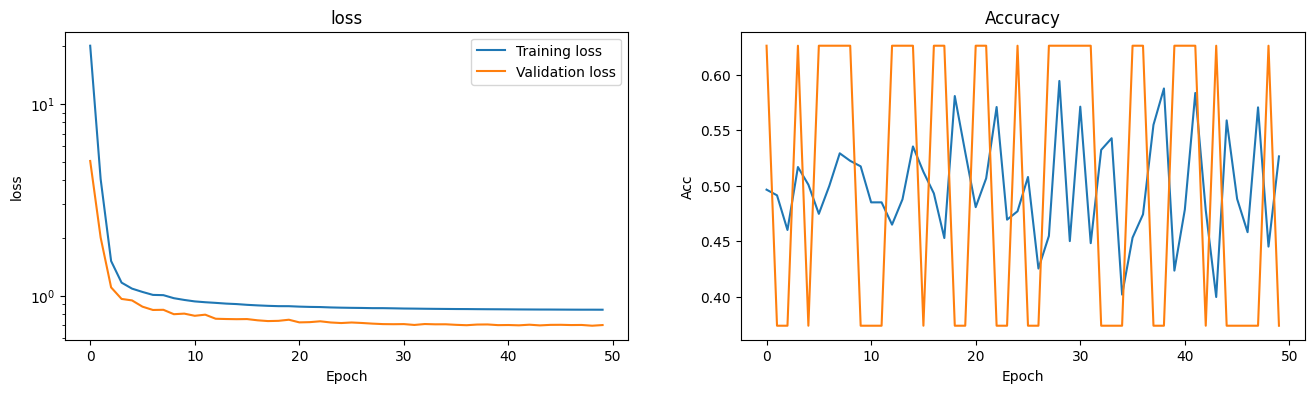

In [43]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_val)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend

In [44]:
from sklearn.metrics import classification_report
import numpy as np

y_val_pred = model.predict(X_val)
y_val_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(Y_validation, axis=1)

print(classification_report(y_val_true, y_val_classes, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       868
           1      0.374     1.000     0.544       518

    accuracy                          0.374      1386
   macro avg      0.187     0.500     0.272      1386
weighted avg      0.140     0.374     0.203      1386



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
# Convert one-hot labels to 1D integer labels (0 or 1)
y_true = np.argmax(Y_test, axis=1)

# Extract predicted probability for the positive class (class 1)
y_prob = pred_test[:,1]

# Create climatology baseline: constant probability = mean positive class rate
p_climatology = np.full_like(y_true, y_true.mean(), dtype=float)

# Compute Brier Scores
bs_model = brier_score_loss(y_true, y_prob)
bs_climo = brier_score_loss(y_true, p_climatology)

# Compute Brier Skill Score
bss = 1 - (bs_model / bs_climo)

print(f"Brier Score (Model): {bs_model:.4f}")
print(f"Brier Score (Climatology): {bs_climo:.4f}")
print(f"Brier Skill Score: {bss:.4f}")

Brier Score (Model): 0.2510
Brier Score (Climatology): 0.2413
Brier Skill Score: -0.0401


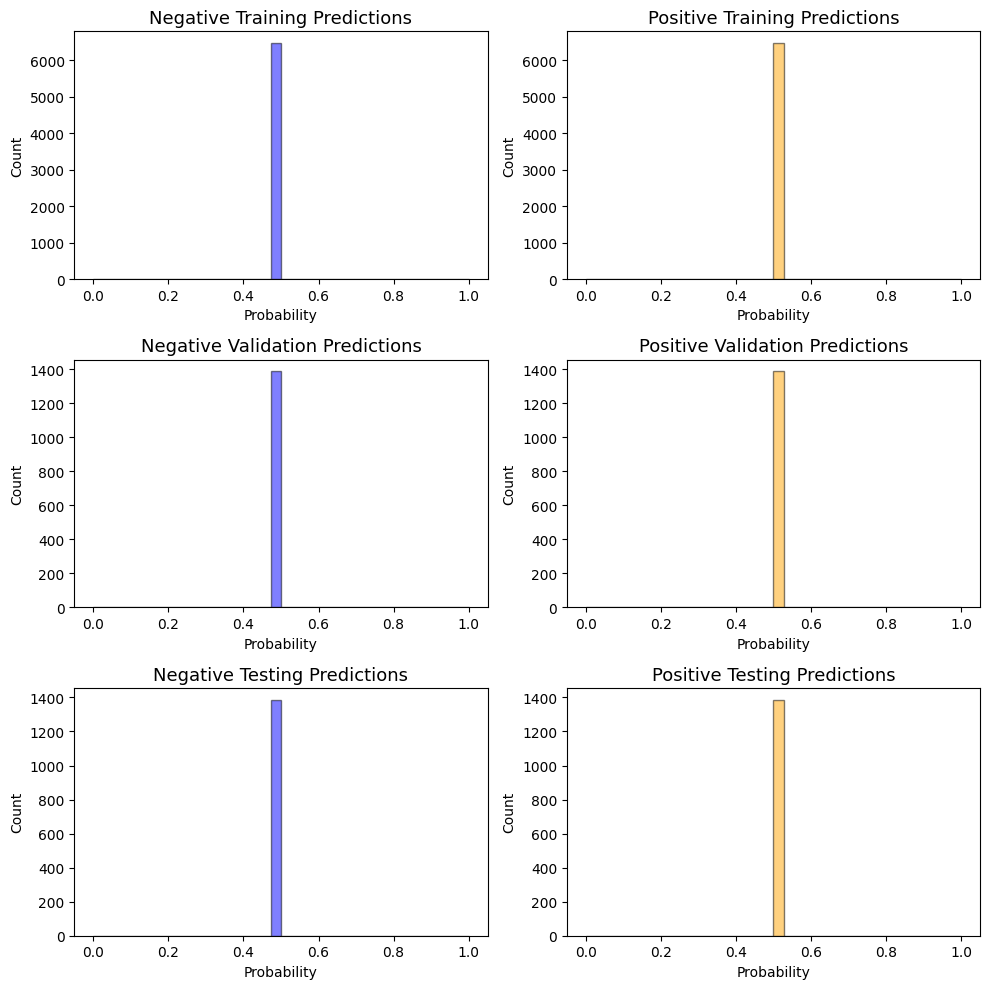

In [46]:
bins = np.linspace(0, 1, 37)  #10 bins from 0.4 to 1
##bin the probabilities
counts_neg_test, edges_neg_test = np.histogram(pred_test[:,0], bins=bins)
counts_pos_test, edges_pos_test = np.histogram(pred_test[:,1], bins=bins)

counts_neg_train, edges_neg_train = np.histogram(pred_train[:,0], bins=bins)
counts_pos_train, edges_pos_train = np.histogram(pred_train[:,1], bins=bins)

counts_neg_val, edges_neg_val = np.histogram(pred_val[:,0], bins=bins)
counts_pos_val, edges_pos_val = np.histogram(pred_val[:,1], bins=bins)

fig, axes = plt.subplots(3, 2, figsize=(10,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

ax1.bar(edges_neg_train[:-1], counts_neg_train, width=np.diff(edges_neg_train), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax1.set_title('Negative Training Predictions', fontsize=13)
ax1.set_xlabel('Probability')
ax1.set_ylabel('Count')

ax2.bar(edges_pos_train[:-1], counts_pos_train, width=np.diff(edges_pos_train), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax2.set_title('Positive Training Predictions', fontsize=13)
ax2.set_xlabel('Probability')
ax2.set_ylabel('Count')

ax3.bar(edges_neg_val[:-1], counts_neg_val, width=np.diff(edges_neg_val), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax3.set_title('Negative Validation Predictions', fontsize=13)
ax3.set_xlabel('Probability')
ax3.set_ylabel('Count')

ax4.bar(edges_pos_val[:-1], counts_pos_val, width=np.diff(edges_pos_val), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax4.set_title('Positive Validation Predictions', fontsize=13)
ax4.set_xlabel('Probability')
ax4.set_ylabel('Count')

ax5.bar(edges_neg_test[:-1], counts_neg_test, width=np.diff(edges_neg_test), 
        edgecolor='black', alpha=0.5, align='edge', color='blue')
ax5.set_title('Negative Testing Predictions', fontsize=13)
ax5.set_xlabel('Probability')
ax5.set_ylabel('Count')

ax6.bar(edges_pos_test[:-1], counts_pos_test, width=np.diff(edges_pos_test), 
        edgecolor='black', alpha=0.5, align='edge', color='orange')
ax6.set_title('Positive Testing Predictions', fontsize=13)
ax6.set_xlabel('Probability')
ax6.set_ylabel('Count')

plt.tight_layout()

In [35]:
#############################tuning#############################

In [47]:
def combined(hp):
    ##set ranges for hyperparameters
    n1 = hp.Int('n1', min_value=120, max_value=128, step=4)
    n2 = hp.Int('n2', min_value=8, max_value=24, step=8)
    n3= hp.Int('n3', min_value=120, max_value=128, step=4)
    n4 = hp.Int('n4', min_value=8, max_value=24, step=8)
    n5= hp.Int('n5', min_value=120, max_value=128, step=4)
    n6 = hp.Int('n6', min_value=8, max_value=24, step=8)
    n7 = hp.Int('n7', min_value=4, max_value=40, step=4)
   

    reg1 = hp.Float('reg1', min_value=0.01, max_value=0.09)
    reg2 = hp.Float('reg2', min_value=0.001, max_value=0.1, default=0.01)
    reg3 = hp.Float('reg3', min_value=0.01, max_value=0.09)
    reg4 = hp.Float('reg4', min_value=0.001, max_value=0.1, default=0.01)
    reg5 = hp.Float('reg5', min_value=0.01, max_value=0.09)
    reg6 = hp.Float('reg6', min_value=0.001, max_value=0.1, default=0.01)
    reg7 = hp.Float('reg7', min_value=0.01, max_value=0.09)
    
    lr = hp.Float('learning_rate', min_value=1e-2, max_value=1)
    ##first layers for U ANN
    input_tensor1 = Input(shape=(int(1332),), name='layer1')
    layer1 = layers.Dense(n1, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg1))(input_tensor1)
   

    layer1 = layers.Dense(n2, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg2))(layer1)
   
    ## second layers for EHF ANN
    input_tensor2 = Input(shape=(int(6660),), name='layer2')
    layer2 = layers.Dense(n3, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg3))(input_tensor2)
    
    layer2 = layers.Dense(n4, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg4))(layer2)
    
    
    ## third layers for GPH ANN
    input_tensor3 = Input(shape=(int(6660),), name='layer3')
    layer3 = layers.Dense(n5, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg5))(input_tensor3)
    
    layer3 = layers.Dense(n6, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg6))(layer3)
    
    ##combine two model inputs
    merge_layer = Concatenate()([layer1,layer2,layer3])

    ##more dense layers
    merge = layers.Dense(n7, activation='leaky_relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= reg7))(merge_layer)

    #decay_rate = learn / epochs
    output_tensor = layers.Dense(2,activation='softmax')(merge)
    model = Model([input_tensor1, input_tensor2, input_tensor3], output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=lr),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [51]:
##intialize/setup the hyperband tuner
import keras_tuner as kt

tuner = kt.tuners.RandomSearch(
    combined, #model
    objective = [kt.Objective('val_loss', 'min'),
                kt.Objective('val_categorical_accuracy', 'max')], #target
    max_trials=1000, #number of iterations of tuning to run
    max_consecutive_failed_trials=3, #number of allowed failed trials
    directory = 'tuning',
    project_name='joint2'
)

Reloading Tuner from tuning/joint2/tuner0.json


In [52]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
##actual tuning process
tuner.search(X_train, Y_train, validation_data=(X_val, Y_validation),
             batch_size=batch_size, epochs=epochs, shuffle=shuffle,
             class_weight = class_weight, callbacks=[stop_early])


Search: Running Trial #82

Value             |Best Value So Far |Hyperparameter
124               |120               |n1
8                 |16                |n2
120               |124               |n3
16                |24                |n4
120               |120               |n5
8                 |24                |n6
24                |4                 |n7
0.017676          |0.021822          |reg1
0.024728          |0.054568          |reg2
0.086884          |0.088267          |reg3
0.09338           |0.072048          |reg4
0.071605          |0.018204          |reg5
0.011577          |0.023764          |reg6
0.020816          |0.068625          |reg7
0.27821           |0.039391          |learning_rate

Train on 6466 samples, validate on 1386 samples
Epoch 1/50
 256/6466 [>.............................] - ETA: 2s - loss: 48.1324 - categorical_accuracy: 0.5430

2025-06-27 18:12:55.190758: W tensorflow/c/c_api.cc:305] Operation '{name:'training/Adam/dense_2/bias/v/Assign' id:739 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_2/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_2/bias/v, training/Adam/dense_2/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


6466/6466 [==============================] - 1s 168us/sample - loss: 40332.3558 - categorical_accuracy: 0.4876 - val_loss: 16789.7551 - val_categorical_accuracy: 0.6263
Epoch 2/50
6466/6466 [==============================] - 1s 105us/sample - loss: 31657.9662 - categorical_accuracy: 0.5082 - val_loss: 17088.2248 - val_categorical_accuracy: 0.6263
Epoch 3/50
6466/6466 [==============================] - 1s 105us/sample - loss: 32819.2836 - categorical_accuracy: 0.4980 - val_loss: 19839.5552 - val_categorical_accuracy: 0.6263
Epoch 4/50
6466/6466 [==============================] - 1s 104us/sample - loss: 73632.3358 - categorical_accuracy: 0.4804 - val_loss: 68392.8470 - val_categorical_accuracy: 0.6263
Epoch 5/50
6466/6466 [==============================] - 1s 104us/sample - loss: 48169.3670 - categorical_accuracy: 0.5158 - val_loss: 24446.3187 - val_categorical_accuracy: 0.3737
Epoch 6/50
 256/6466 [>.............................] - ETA: 0s - loss: 24033.5840 - categorical_accuracy: 0.40

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train,Y_train, validation_data=(X_val, Y_validation),
                    batch_size=batch_size, epochs=epochs, shuffle=shuffle,class_weight = class_weight)

In [ ]:
train_loss=model.history.history['loss']
val_loss=model.history.history['val_loss']
    
cat_acc=model.history.history['categorical_accuracy']
val_acc=model.history.history['val_categorical_accuracy']
        
pred = model.predict(X_all)
pred_val = model.predict(X_val)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

# Look at the optimization history
fig, (ax1,ax2) = plt.subplots(1,2, figsize=plt.figaspect(0.25))
ax1.plot(train_loss, label='Training loss')
ax1.plot(val_loss, label='Validation loss')
ax1.set_yscale('log')
ax1.set_title('loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss')
ax1.legend()

ax2.plot(cat_acc, label='Training ACC')
ax2.plot(val_acc, label='Validation ACC')
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Acc')
ax2.legend